# Weapons Detection - YOLO and Faster R-CNN

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

fatal: destination path 'cocoapi' already exists and is not an empty directory.
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/p

### Dataset

Download and extract data, present in a zip file at (github link)

In [0]:
%%shell

# download the dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
git clone https://github.com/SadCl0wn/mirto.git

# extract it in the current folder
#unzip mirto/ML-Project.zip
unzip ML-Project.zip

The data is structured as follows
```
ML-Project/
  images/
    armas (1).jpg
    armas (2).jpg
    armas (3).jpg
    armas (4).jpg
    ...
  annotations/
    armas (1).xml
    armas (2).xml
    armas (3).xml
    armas (4).xml
    ...
```

Here is one example of an image in the dataset.

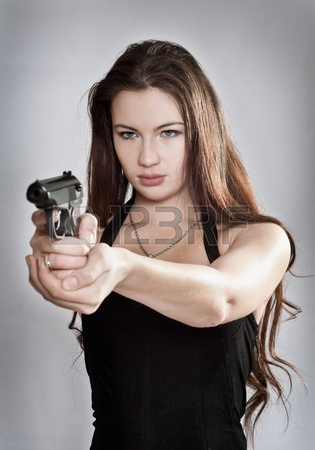

In [3]:
from PIL import Image
Image.open('ML-Project/images/armas (12).jpg')

Defining a `torch.utils.data.Dataset` class for this dataset.

In [4]:
!pip3 install 'xmltodict'

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import xmltodict

class WeaponDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(i for i in os.listdir(os.path.join(root, "images"))
                                 if i.lower().endswith(('.png', '.jpg', '.jpeg'))))
        self.annotations = list(sorted(a for a in os.listdir(os.path.join(root, "annotations"))
                                        if a.lower().endswith(('.xml'))))

    def __getitem__(self, idx):
        # load images ad annotations
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")
        
        boxes = []
        
        x = xmltodict.parse(open(annotations_path, 'rb'))        
        objects = []

        if isinstance(x['annotation']['object'], list):
          objects = x['annotation']['object']
        else:
          objects.append(x['annotation']['object'])
        
        for obj in objects:
            bndbox = obj['bndbox']
            bndbox = np.array([int(bndbox['xmin']), int(bndbox['ymin']), 
                               int(bndbox['xmax']), int(bndbox['ymax'])])
            box = [None] * 4
            box[0] = bndbox[0]
            box[1] = bndbox[1]
            box[2] = bndbox[2]
            box[3] = bndbox[3]             
            boxes.append(box)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones(len(objects), dtype=torch.int64)
        #labels = torch.ones((len(self.imgs)), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros(len(objects), dtype=torch.int64)
        #iscrowd = torch.zeros((len(self.imgs)), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Defining the model

In this work we will use Faster R-CNN. 

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (weapon) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
                                                
    return model

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
#git clone https://github.com/pytorch/vision.git
#git checkout v0.3.0

cd mirto

cp Faster_R_CNN/utils.py ../
cp Faster_R_CNN/transforms.py ../
cp Faster_R_CNN/coco_eval.py ../
cp Faster_R_CNN/engine.py ../
cp Faster_R_CNN/coco_utils.py ../

cd YOLOv3
cp -r ./ ../../
cd ../../weights/

#downloading the weights
bash download_weights.sh

#downloading the weights
#bash YOLO/weigths/download_weights.sh

--2020-02-18 15:16:36--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-02-18 15:16:36--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-02-18 15:16:36--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieve


Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [0]:
from engine import train_one_epoch, evaluate
import utils
import copy
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model. 

### Prepare dataloader

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [0]:
# use our dataset and defined transformations
dataset = WeaponDataset('ML-Project', get_transform(train=True))
dataset_val = WeaponDataset('ML-Project', get_transform(train=False))
dataset_test = WeaponDataset('ML-Project', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_val = torch.utils.data.Subset(dataset_val, indices[30:40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Check dataset sizes
print('Train Dataset: {}'.format(len(dataset)))
print('Validation Dataset: {}'.format(len(dataset_val)))
print('Test Dataset: {}'.format(len(dataset_test)))

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Move the needed modules in root

In [0]:
%%shell

#git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git
#cd PyTorch-YOLOv3
#cp -r ./ ../
#cd weights/
#downloading the weights
#bash download_weights.sh

### Define YOLO model

In [0]:
from models import *
from yolo_utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

config_path='config/yolov3.cfg'
weights_path='weights/yolov3.weights'
class_path='data/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
yolo_model = Darknet(config_path, img_size=img_size)
yolo_model.load_darknet_weights(weights_path)
yolo_model.cuda()
yolo_model.eval()
classes = yolo_utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = yolo_model(input_img)
        detections = yolo_utils.non_max_suppression(detections, conf_thres, nms_thres)      
    return detections[0]

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [0]:
# let's train it for 10 epochs
num_epochs = 3

losses = []
losses_classifier = []
losses_box_reg = []
losses_objectness = []
losses_rpn_box_reg = []
train_acc = []
val_acc = []

best_net = None
best_accuracy = 0.0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    losses_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)    
    
    # update the learning rate
    lr_scheduler.step()
        
    # evaluate on the train dataset
    _, confmat = evaluate(model, 
                          data_loader, 
                          conf_threshold=0.9, 
                          iou_threshold=0.5, device=device)
    train_acc.append(confmat.compute()[0].item())
       
    # evaluate on the validation dataset
    _, confmat = evaluate(model, 
                          data_loader_val, 
                          conf_threshold=0.9, 
                          iou_threshold=0.5, device=device)
    
    accuracy = confmat.compute()[0].item()
    val_acc.append(accuracy)
    print(accuracy)
    print(best_accuracy)
    
    # Update the best model
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_net = copy.deepcopy(model)

    # trace losses
    losses.extend(losses_log[0])
    losses_classifier.extend(losses_log[1])
    losses_box_reg.extend(losses_log[2])
    losses_objectness.extend(losses_log[3])
    losses_rpn_box_reg.extend(losses_log[4])


utils.plot_loss_accuracy_trend([losses, 
                                losses_classifier, 
                                losses_box_reg, 
                                losses_objectness, 
                                losses_rpn_box_reg], [train_acc, val_acc])


# final test on test set
_, _ = evaluate(best_net, data_loader_test, conf_threshold=0.9, iou_threshold=0.5, device=device)


### Testing the model

And let's now pick one image and visualize the top predicted boxes (confidence score grater than a threshold).

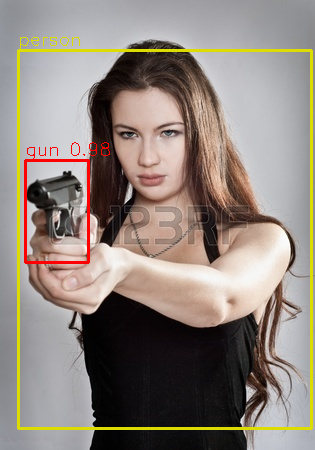

In [12]:
import cv2
from google.colab.patches import cv2_imshow

WEAPON_CATEGORY_NAMES = ['__background__', 'gun']

# given an image
pil_img = Image.open('ML-Project/images/armas (12).jpg').convert("RGB")

# detect people with yolo
detections = detect_image(pil_img)

boxes = []
labels = []

img = np.array(pil_img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    # browse detections and save bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        if cls_pred == 0.0:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            boxes.append([x1, y1, x1+box_w, y1+box_h])
            labels.append('person')

            # extend the area around person (20 pixel)
            xmin = x1 - 20
            ymin = y1 - 20
            xmax = x1+box_w + 20
            ymax = y1+box_h + 20

            # crop the initial image according to this new coordinates
            potential_area = pil_img.crop((xmin.item(), ymin.item(), xmax.item(), ymax.item()));
            transform = get_transform(train=False)
            potential_area, _ = transform(potential_area, _)
            
            # put the Faster R-CNN in evaluation mode and detect the image
            model.eval()
            with torch.no_grad():
                prediction = model([potential_area.to(device)])
        
            # for each box found by Faster R-CNN in the current crop of the image
            for i in range(len(prediction[0]['boxes'])):
                score = round(prediction[0]['scores'][i].item(), 2)
                
                # if the confidence score is greater than a threshold
                if score > 0.7:
                    label = WEAPON_CATEGORY_NAMES[int(prediction[0]['labels'][i].item())]
                    box = prediction[0]['boxes'][i]
                    txt = '{} {}'.format(label, score)
                    
                    # update the box values so that the new coordinates identify the object in the original image
                    box[0] += xmin
                    box[1] += ymin
                    box[2] += xmin
                    box[3] += ymin
                    
                    # add the box and the text label to the lists
                    boxes.append(box)
                    labels.append(txt)
            

# read the original image
img = cv2.imread('ML-Project/images/armas (12).jpg') # Read image with cv2

# add boxes found to the image
for i, box in enumerate(boxes):
    color = (0, 220, 220)
    if 'gun' in labels[i]:
      color = (0, 0, 255)
    cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=color, thickness=2)
    cv2.putText(img, labels[i], (int(box[0]), int(box[1])-5),  cv2.FONT_HERSHEY_SIMPLEX, 0.6, color=color,thickness=1)

cv2_imshow(img)


### Testing the model on video

And let's now pick one video and visualize the top predicted boxes (confidence score grater than a threshold).

In [0]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from matplotlib.pyplot import figure
from matplotlib.pyplot import title
from matplotlib.pyplot import imshow
from matplotlib.pyplot import show

WEAPON_CATEGORY_NAMES = ['__background__', 'gun']

videopath = '6.mp4'

vid = cv2.VideoCapture(videopath)

transform = get_transform(train=False)
model.eval()


for ii in range(4000):
    ret, frame = vid.read()
    pilimg = Image.fromarray(frame)
    img, _ = transform(pilimg, _)

    with torch.no_grad():
      prediction = model([img.to(device)])

    for i in range(len(prediction[0]['boxes'])):
        score = round(prediction[0]['scores'][i].item(), 2)

        if score > 0.8:
            label = WEAPON_CATEGORY_NAMES[int(prediction[0]['labels'][i].item())]
            box = prediction[0]['boxes'][i]
            txt = '{} {}'.format(label, score)
            img = cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0, 255, 0), thickness=2)
            cv2.putText(frame, txt, (int(box[0]), int(box[1])-5),  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,220,0),thickness=1)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)


### Testing the model on video

**WARNING: this works only locally!!**


In [0]:
import cv2

WEAPON_CATEGORY_NAMES = ['__background__', 'gun']

videopath = '6.mp4'

vid = cv2.VideoCapture(videopath)

transform = get_transform(train=False)
model.eval()

while(True):
#for ii in range(4000):
    try:
        ret, frame = vid.read()
        pilimg = Image.fromarray(frame)
        img, _ = transform(pilimg, None)

        with torch.no_grad():
          prediction = model([img.to(device)])

        for i in range(len(prediction[0]['boxes'])):
            score = round(prediction[0]['scores'][i].item(), 2)

            if score > 0.8:
                label = WEAPON_CATEGORY_NAMES[int(prediction[0]['labels'][i].item())]
                box = prediction[0]['boxes'][i]
                txt = '{} {}'.format(label, score)
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0, 255, 0), thickness=2)
                cv2.putText(frame, txt, (int(box[0]), int(box[1])-5),  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,220,0),thickness=1)

        cv2.imshow('Weapons Detection',frame)
        
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    
    except Exception:
        break

vid.release()
cv2.destroyAllWindows()